# Setup

In [1]:
from sklearn.datasets import load_wine
from sklearn.datasets import load_breast_cancer
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import random

from lib.baseline import *
from lib.baycon import execute

from lib.CF_De.cfde import CF_Descent
from lib.cf_a.cfae import CF_Ascent
from lib.neighborSearch.cfnMarginal import neighborSearchMarginal as neighborSearch
from dataclasses import dataclass
from lib.eval.generator import run, returnNames
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

import pickle
import json
import pathlib
import os
import time

%load_ext autoreload
%autoreload 2

In [2]:
data_set = "breast_cancer"
cf_amount = 25
random_state = 42

match data_set:
    case "breast_cancer":
        X, true_y = load_breast_cancer(return_X_y=True)
        nc = 2
    case "blobs":
        nc = 3
        X, true_y = make_blobs(centers=nc, cluster_std=2, n_features=2, n_samples=250, random_state=random_state)

#X, true_y = load_wine(return_X_y=True)
# X, true_y = load_breast_cancer(return_X_y=True)
# X, true_y = make_blobs(centers=3, cluster_std=2, n_features=2, n_samples=250)

X = StandardScaler().fit_transform(X)


random.seed(random_state)

km = KMeans(n_clusters=nc, random_state=random_state)
y = km.fit_predict(X)
centers = km.cluster_centers_

@dataclass
class CounterfactualData:
    cf: np.array
    instance: np.array
    target: int
    instance_label: float


cfs = []
for i in range(cf_amount):
    index = random.randint(0, len(X)-1)
    label = y[index]

    foo = set(range(nc))
    foo.remove(label)
    target = random.choice(list(foo))

    cfs.append(CounterfactualData([], index, target, label))

In [3]:
def pickle_cfs(cf_obj):
    name = cf_obj['name']
    p = pathlib.Path(f'./testdata/cfs/{data_set}/{name}.pkl')
    p.parent.mkdir(parents=True, exist_ok=True)
    with open(p, 'wb') as f:
        pickle.dump(cf_obj, f, protocol=pickle.HIGHEST_PROTOCOL)

def pickle_res(res_obj, method_name):
    p = pathlib.Path(f'./testdata/eval/{data_set}/{method_name}.pkl')
    p.parent.mkdir(parents=True, exist_ok=True)
    with open(p, 'wb') as f:
        pickle.dump(res_obj, f, protocol=pickle.HIGHEST_PROTOCOL)

# Cross testing of methods

## Baseline

In [4]:
from lib.baseline import baseline_explainer
from lib.baycon import baycon_explainer
from sklearn.ensemble import RandomForestClassifier

explainer = baycon_explainer
baseline_cfs = []
runtimes = []
for cf in cfs:
    s = time.time()
    classifier = RandomForestClassifier(n_estimators=100)
    baseline_cf = baseline_explainer(X, y, classifier, explainer, cf.instance, target_cluster=int(cf.target))
    runtimes.append(time.time() - s)
    baseline_cfs.append(CounterfactualData(baseline_cf, cf.instance, cf.target, cf.instance_label))

baseLine = {
    "name": "Baseline",
    "counterfactuals": baseline_cfs
}
pickle_cfs(baseLine)

res, _ = run(baseLine, centers, X, y, runtimes)
pickle_res(res, baseLine['name'])

Done training classifier. Score: 1.0
--- Executing... Initial Instance: 114 Target: 0 Run: 0 ---
--- Step 0: Load internal objects ---
--- Step 1: Generate initial neighbours ---
Generated initial neighbours: (779) CFs (0)
Re-training surrogate model with data size: 779
--- Step 2: Explore neighbourhood ---
--- epoch 1 ----
Generating neighbors for 1 near best instances
Generated neighbours: (3) Unique overall (3)
Generated random instances: (3729)
Predicted top: 20 Counterfactuals: 0
Known alternatives: 799
Best instance score 0.0000 (X 0.99882 Y 0.0 F 0.96667), found on epoch: 0
Re-training surrogate model with data size: 799
--- epoch 2 ----
Generating neighbors for 20 near best instances
Generated neighbours: (128) Unique overall (131)
Generated random instances: (3713)
Predicted top: 20 Counterfactuals: 0
Known alternatives: 819
Best instance score 0.0000 (X 0.99882 Y 0.0 F 0.96667), found on epoch: 0
Re-training surrogate model with data size: 819
--- epoch 3 ----
Generating neig

## Baycon - Model Agnostic

In [5]:
from lib.ext.baycon.common.Target import Target
baycon_cfs = []
modes = ['kmeans', 'model_agnostic']
run_mode = modes[1]
runtimes = []

pred = km.predict(X)
pred = [str(l) for l in pred]
stacked = np.column_stack((X, pred))
df = pd.DataFrame(stacked, columns=[f'x{i+1}' for i in range(X.shape[1])]+['label'], dtype=float)
df

baycon_cfs = []
for cf in cfs:
    point_idx = cf.instance
    point_pred = int(km.predict([X[point_idx]])[0])
    if run_mode == modes[0]:
        t = Target(target_type="clustering_kmeans", target_feature="label", target_value=int(cf.target))
    elif run_mode == modes[1]:
        t = Target(target_type="model_agnostic", target_feature="label", target_value=int(cf.target))

    s = time.time()
    baycon_cf, _predictions, _initial_instance, _initial_prediction = execute(df, km, t, point_idx)
    runtimes.append(time.time() - s)
    baycon_cfs.append(CounterfactualData(baycon_cf, cf.instance, cf.target, cf.instance_label))

Baycon = {
    "name": "Baycon - Model Agnostic",
    "counterfactuals": baycon_cfs
}

pickle_cfs(Baycon)

res, _ = run(Baycon, centers, X, y, runtimes)
print(res)
pickle_res(res, Baycon['name'])

--- Executing... Initial Instance: 114 Target: 0 Run: 0 ---
--- Step 0: Load internal objects ---
--- Step 1: Generate initial neighbours ---
Generated initial neighbours: (771) CFs (6)
Re-training surrogate model with data size: 771
--- Step 2: Explore neighbourhood ---
--- epoch 1 ----
Generating neighbors for 1 near best instances
Generated neighbours: (89) Unique overall (89)
Generated random instances: (3074)
Predicted top: 20 Counterfactuals: 15
Found new best [-1.53404353 -0.80508343 -1.48816212  0.82344052 -0.90266389 -0.42320519
 -0.80690922  1.30130806 -0.59371141  1.91835712 -0.05770549 -0.87966541
  0.87751106 -0.69021737  1.19388841 -0.18712594  0.02308669 -0.22646693
 -0.41920995  0.00419713  0.9697385  -0.98638119 -1.27427429 -1.0480379
  1.75481236 -0.11364664 -0.12755887 -0.14627009  1.87785502  0.98386255], with fitness score 0.1413 (X 0.88296 Y 0.24 F 0.66667), oversampling
Known alternatives: 791
Best instance score 0.1413 (X 0.88296 Y 0.24 F 0.66667), found on epoc

## CFDE

In [6]:
cfde_cfs = []
amount = 20
runtimes = []
for cf in cfs:
    temp_cfs = []
    for i in range(amount):
        s = time.time()
        x1, cf1, h1 = CF_Descent(X=X,y=y,target=cf.target,centers=centers,instance_index=cf.instance, stop_count=20)
        runtimes.append(time.time() - s)
        temp_cfs.append(cf1)
    cfde_cfs.append(CounterfactualData(temp_cfs, cf.instance, cf.target, cf.instance_label))    

cfde = {
    "name": "CF-DE",
    "counterfactuals": cfde_cfs
}

pickle_cfs(cfde)

res, _ = run(cfde, centers, X, y, runtimes)
pickle_res(res, cfde['name'])

Starting on: CF-DE
Removing invalid counterfactuals!!!


## CFAE

In [7]:
cfae_cfs = []
amount = 20
runtimes = []
for cf in cfs:
    temp_cfs = []
    for i in range(amount):
        s = time.time()
        x2, cf2, h2 = CF_Ascent(X=X,y=y,target=cf.target,centers=centers,instance_index=cf.instance, stop_count=20, center_mode=False)
        runtimes.append(time.time() - s)
        temp_cfs.append(cf2)
    cfae_cfs.append(CounterfactualData(temp_cfs, cf.instance, cf.target, cf.instance_label))

cfae = {
    "name": "CF-AE",
    "counterfactuals": cfae_cfs
}

pickle_cfs(cfae)

res, _ = run(cfae, centers, X, y, runtimes)
pickle_res(res, cfae['name'])

Starting on: CF-AE
Removing invalid counterfactuals!!!


## NeighborSearch

In [8]:
ns_cfs = []
runtimes = []
for cf in cfs:
    s = time.time()
    i, new_cfs = neighborSearch(X=X, y=y, target=cf.target, model=km, instance_index=cf.instance, n=15)
    runtimes.append(time.time() - s)
    ns_cfs.append(CounterfactualData(new_cfs, cf.instance, cf.target, cf.instance_label))

nfs = {
    "name": "NeighborSearch",
    "counterfactuals": ns_cfs
}

pickle_cfs(nfs)

res, _ = run(nfs, centers, X, y,runtimes)
pickle_res(res, nfs['name'])

Starting on: NeighborSearch
Removing invalid counterfactuals!!!


## Dice Mod

In [9]:
from lib.dice_mod import Gainer, gradient_ascent, adam_opt, random_opt
from scipy.spatial.distance import pdist
from lib.util import sparsity_fix


dice_cfs = []
runtimes = []
for cf in cfs:
    instance = X[cf.instance].reshape(1, -1)
    s = time.time()
    gainer = Gainer(centers, X, cf.target, instance, eps=0)
    dice_cf = np.array([adam_opt(instance, gainer.gain, max_iter=1000, lr=1)[0][0]])
    runtimes.append(time.time() - s)
    print(dice_cf.shape)
    print([km.predict(cf.reshape(1,-1)) for cf in dice_cf])
    dice_cfs.append(CounterfactualData(dice_cf, cf.instance, cf.target, cf.instance_label))

# centers = km.cluster_centers_
# dists = np.linalg.norm(dice_cf.reshape(1, -1) - centers, axis=1)
# print(dists)

dice_mod = {
    "name": "dice_mod",
    "counterfactuals": dice_cfs
}

pickle_cfs(dice_mod)

res, _ = run(dice_mod, centers, X, y, runtimes)
pickle_res(res, dice_mod['name'])


runtimes_fix = []
dice_cfs_fixed =  []
for i,cf in enumerate(dice_cfs):
    s = time.time()
    fixed = sparsity_fix(cf.cf, X[cf.instance, :].reshape(1, -1), km)
    runtimes_fix.append(runtimes[i] + (time.time() - s))
    new_cf = CounterfactualData(
        fixed, 
        cf.instance, cf.target, cf.instance_label
    )
    dice_cfs_fixed.append(new_cf)



dice_mod_sparsity_fix = {
    "name": "dice_mod_sparsity_fix",
    "counterfactuals": dice_cfs_fixed
}

pickle_cfs(dice_mod_sparsity_fix)

res, _ = run(dice_mod_sparsity_fix, centers, X, y, runtimes_fix)
pickle_res(res, dice_mod_sparsity_fix['name'])

X: (569, 30)
C: (2, 30)
x: (1, 30)
iter: 110, score: 0.8499335234278281
(1, 30)
[array([0], dtype=int32)]
X: (569, 30)
C: (2, 30)
x: (1, 30)
iter: 112, score: 0.861102589318129
(1, 30)
[array([0], dtype=int32)]
X: (569, 30)
C: (2, 30)
x: (1, 30)
iter: 108, score: 0.8905798449976869
(1, 30)
[array([0], dtype=int32)]
X: (569, 30)
C: (2, 30)
x: (1, 30)
iter: 111, score: 0.8737501547169958
(1, 30)
[array([0], dtype=int32)]
X: (569, 30)
C: (2, 30)
x: (1, 30)
iter: 112, score: 0.8945683467406988
(1, 30)
[array([1], dtype=int32)]
X: (569, 30)
C: (2, 30)
x: (1, 30)
iter: 126, score: 0.8606015712462629
(1, 30)
[array([1], dtype=int32)]
X: (569, 30)
C: (2, 30)
x: (1, 30)
iter: 133, score: 0.9402864917056933
(1, 30)
[array([1], dtype=int32)]
X: (569, 30)
C: (2, 30)
x: (1, 30)
iter: 111, score: 0.8942000823153132
(1, 30)
[array([1], dtype=int32)]
X: (569, 30)
C: (2, 30)
x: (1, 30)
iter: 104, score: 0.8185183627280299
(1, 30)
[array([1], dtype=int32)]
X: (569, 30)
C: (2, 30)
x: (1, 30)
iter: 109, s

## Dice Mod - Random

In [10]:
from lib.dice_mod import Gainer, gradient_ascent, adam_opt, random_opt
from scipy.spatial.distance import pdist
import torch

dice_cfs = []
count = 10
runtimes = []
torch.manual_seed(42)

for cf in cfs:
    instance = X[cf.instance].reshape(1, -1)
    s = time.time()
    gainer = Gainer(centers, X, cf.target, instance, eps=0)
    dice_cf = np.array([random_opt(instance, gainer.gain)[0][0]  for _ in range(count)])
    runtimes.append(time.time() - s)
    print(dice_cf.shape)
    print([km.predict(cf.reshape(1,-1)) for cf in dice_cf])
    dice_cfs.append(CounterfactualData(dice_cf, cf.instance, cf.target, cf.instance_label))

# centers = km.cluster_centers_
# dists = np.linalg.norm(dice_cf.reshape(1, -1) - centers, axis=1)
# print(dists)

dice_mod = {
    "name": "dice_mod_random",
    "counterfactuals": dice_cfs
}

pickle_cfs(dice_mod)

res, _ = run(dice_mod, centers, X, y, runtimes)
pickle_res(res, dice_mod['name'])

X: (569, 30)
C: (2, 30)
x: (1, 30)
iter: 158, score: 0.38836097362743666
iter: 170, score: 0.8422174023427769
iter: 169, score: 0.8389909828037
iter: 164, score: 0.34332993273121276
iter: 142, score: 0.29809490774811453
iter: 164, score: 0.4117129350041305
iter: 153, score: 0.8427608786606812
iter: 161, score: 0.3772843409351361
iter: 160, score: 0.3846758671831146
iter: 160, score: 0.359275385881189
(10, 30)
[array([0], dtype=int32), array([0], dtype=int32), array([0], dtype=int32), array([0], dtype=int32), array([1], dtype=int32), array([0], dtype=int32), array([0], dtype=int32), array([0], dtype=int32), array([0], dtype=int32), array([0], dtype=int32)]
X: (569, 30)
C: (2, 30)
x: (1, 30)
iter: 168, score: 0.8638494404523932
iter: 161, score: 0.3749280988243541
iter: 160, score: 0.8618315495630952
iter: 156, score: 0.7077493119923725
iter: 169, score: 0.8634632668602215
iter: 166, score: 0.8612864373485751
iter: 158, score: 0.42816903336514717
iter: 154, score: 0.3786576448704111
iter

## threshold tree / imm

In [11]:
from lib.threshold_tree import ThresholdTree

tt = ThresholdTree(km, centers, X, y)
tt_dtc_cfs = []
runtimes_dtc = []

tt_dtc_prime_cfs = []
runtimes_prime_dtc = []

tt_imm_cfs = []
runtimes_imm = []

tt_imm_prime_cfs = []
runtimes_prime_imm = []

tt_rf_cfs = []
runtimes_rf = []

for cf in cfs:
    s = time.time()
    tt_cf = tt.find_counterfactuals_dtc(X[cf.instance], cf.target)
    runtimes_dtc.append(time.time() - s)
    cf_data = CounterfactualData(tt_cf, cf.instance, cf.target, cf.instance_label)
    tt_dtc_cfs.append(cf_data)

    s = time.time()
    tt_cf_prime = tt.plausibility_fix(tt_cf, X[cf.instance], cf.target, "DTC")
    runtimes_prime_dtc.append(runtimes_dtc[-1] + time.time() - s)
    cf_data = CounterfactualData(tt_cf_prime, cf.instance, cf.target, cf.instance_label)
    tt_dtc_prime_cfs.append(cf_data)

    s = time.time()
    tt_imm_cf = tt.find_counterfactuals_imm(X[cf.instance], cf.target)
    runtimes_imm.append(time.time() - s)
    cf_data = CounterfactualData(tt_imm_cf, cf.instance, cf.target, cf.instance_label)
    tt_imm_cfs.append(cf_data)

    s = time.time()
    tt_imm_cf_prime = tt.plausibility_fix(tt_imm_cf, X[cf.instance], cf.target, "IMM")
    runtimes_prime_imm.append(runtimes_imm[-1] + time.time() - s)
    tt_imm_prime_cfs.append(cf_data)
    cf_data = CounterfactualData(tt_imm_cf_prime, cf.instance, cf.target, cf.instance_label)

    s = time.time()
    rf_cf = tt.find_counterfactuals_rf(X[cf.instance], cf.target)
    runtimes_rf.append(time.time() - s)
    cf_data = CounterfactualData(rf_cf, cf.instance, cf.target, cf.instance_label)
    tt_rf_cfs.append(cf_data)



tt_dtc = {
    "name": "ThresholdTree_DTC",
    "counterfactuals": tt_dtc_cfs
}
pickle_cfs(tt_dtc)

res, _ = run(tt_dtc, centers, X, y, runtimes_dtc)
pickle_res(res, tt_dtc['name'])

tt_dtc_prime = {
    "name": "ThresholdTree_DTC_Post_Proccesing",
    "counterfactuals": tt_dtc_prime_cfs
}
pickle_cfs(tt_dtc_prime)

res, _ = run(tt_dtc_prime, centers, X, y, runtimes_prime_dtc)
pickle_res(res, tt_dtc_prime['name'])


tt_imm = {
    "name": "ThresholdTree_IMM",
    "counterfactuals": tt_imm_cfs
}
pickle_cfs(tt_imm)

res, _ = run(tt_imm, centers, X, y, runtimes_imm)
pickle_res(res, tt_imm['name'])

tt_imm_prime = {
    "name": "ThresholdTree_IMM_Post_Proccesing",
    "counterfactuals": tt_imm_prime_cfs
}
pickle_cfs(tt_imm_prime)

res, _ = run(tt_imm_prime, centers, X, y, runtimes_prime_imm)
pickle_res(res, tt_imm_prime['name'])

tt_rf = {
    "name": "ThresholdTree_RF",
    "counterfactuals": tt_rf_cfs
}
pickle_cfs(tt_rf)

res, _ = run(tt_rf, centers, X, y, runtimes_rf)
pickle_res(res, tt_rf['name'])

DTC accuracy: 0.9982425307557118
Random Forest accuracy: 0.9947275922671354
DTC accuracy: 0.9982425307557118
Random Forest accuracy: 0.9947275922671354
DTC accuracy: 0.9982425307557118
Random Forest accuracy: 0.9947275922671354
DTC accuracy: 0.9982425307557118
Random Forest accuracy: 0.9947275922671354
DTC accuracy: 0.9982425307557118
Random Forest accuracy: 0.9947275922671354
DTC accuracy: 0.9982425307557118
Random Forest accuracy: 0.9947275922671354
DTC accuracy: 0.9982425307557118
Random Forest accuracy: 0.9947275922671354
DTC accuracy: 0.9982425307557118
Random Forest accuracy: 0.9947275922671354
DTC accuracy: 0.9982425307557118
Random Forest accuracy: 0.9947275922671354
DTC accuracy: 0.9982425307557118
Random Forest accuracy: 0.9947275922671354
DTC accuracy: 0.9982425307557118
Random Forest accuracy: 0.9947275922671354
DTC accuracy: 0.9982425307557118
Random Forest accuracy: 0.9947275922671354
DTC accuracy: 0.9982425307557118
Random Forest accuracy: 0.9947275922671354
DTC accuracy

# Loading method counterfactuals

In [12]:
methods = []
base_path = f'./testdata/cfs/{data_set}'
for p in os.listdir(base_path):
    with open(os.path.join(base_path, p), 'rb') as file:
        cf_obj = pickle.load(file)
        methods.append(cf_obj)

methodNames = [m['name'] for m in methods]
print(methodNames)

['Baycon - Model Agnostic', 'dice_mod_sparsity_fix', 'CF-DE', 'ThresholdTree_RF', 'dice_mod', 'CF-AE', 'dice_mod_random', 'ThresholdTree_IMM_Post_Proccesing', 'Baseline', 'ThresholdTree_IMM', 'ThresholdTree_DTC_Post_Proccesing', 'NeighborSearch', 'ThresholdTree_DTC']


# Loading evaluation results

In [13]:
results = {}
base_path = f'./testdata/eval/{data_set}'
for m in methods:
    with open(os.path.join(base_path, f"{m['name']}.pkl"), 'rb') as handle:
        res = pickle.load(handle)
        results[m['name']] = res

In [14]:
for r in results['Baycon - Model Agnostic']:
    print(r)

[array([7.84648292]), array([0.43333333]), array([-1.36260408]), array([False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False]), np.float64(1.070775154670939), array([1.]), 16.059717416763306]
[array([7.40468253]), array([0.33333333]), array([-1.4329292]), array([False, False, False, ..., False, False, False], shape=(2156,)), np.float64(1.0600397397325039), array([1.]), 12.8421370

# Print & plot evaluation results

In [15]:
max_name_length = max(len(m) for m in methodNames)
mean_results = []

for i, n in enumerate(returnNames()):
    row = {}
    for m in methodNames:
        # Get the results for the current method m and metric i
        # so res = list of results, one number for each cf for each instance we're explaining

        print(f"i: {i}, m: {m}, n: {n}")
        res = [row[i] for row in results[m]]

        flat = []
        for metric in res:
            try:
                flat.extend(metric)
            except TypeError:
                flat.append(metric)
        
        # We are getting the mean of ALL CFs for ALL instances
        # Get mean for each instance first
        instance_means = []
        for j in range(cf_amount):
            mean = np.mean(res[j])
            
            # If no CFs were found, res[j] is empty, and np.mean() returns NaN
            if not np.isnan(mean):
                instance_means.append(mean)

        # Finally, get the means of the instance means. If this is a NaN, 
        # no VALID CFs were found for any instance
        row[m] = np.mean(instance_means)

    mean_results.append(row)

mean_results_df = pd.DataFrame(mean_results, index=returnNames())
mean_results_df


i: 0, m: Baycon - Model Agnostic, n: Similarity
i: 0, m: dice_mod_sparsity_fix, n: Similarity
i: 0, m: CF-DE, n: Similarity
i: 0, m: ThresholdTree_RF, n: Similarity
i: 0, m: dice_mod, n: Similarity
i: 0, m: CF-AE, n: Similarity
i: 0, m: dice_mod_random, n: Similarity
i: 0, m: ThresholdTree_IMM_Post_Proccesing, n: Similarity
i: 0, m: Baseline, n: Similarity
i: 0, m: ThresholdTree_IMM, n: Similarity
i: 0, m: ThresholdTree_DTC_Post_Proccesing, n: Similarity
i: 0, m: NeighborSearch, n: Similarity
i: 0, m: ThresholdTree_DTC, n: Similarity
i: 1, m: Baycon - Model Agnostic, n: Minimality
i: 1, m: dice_mod_sparsity_fix, n: Minimality
i: 1, m: CF-DE, n: Minimality
i: 1, m: ThresholdTree_RF, n: Minimality
i: 1, m: dice_mod, n: Minimality
i: 1, m: CF-AE, n: Minimality
i: 1, m: dice_mod_random, n: Minimality
i: 1, m: ThresholdTree_IMM_Post_Proccesing, n: Minimality
i: 1, m: Baseline, n: Minimality
i: 1, m: ThresholdTree_IMM, n: Minimality
i: 1, m: ThresholdTree_DTC_Post_Proccesing, n: Minimality
i

/nix/store/1g7fmqnc7ashj2m9ary5dr19qax22j4d-python3.12-numpy-2.2.2/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/nix/store/1g7fmqnc7ashj2m9ary5dr19qax22j4d-python3.12-numpy-2.2.2/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,Baycon - Model Agnostic,dice_mod_sparsity_fix,CF-DE,ThresholdTree_RF,dice_mod,CF-AE,dice_mod_random,ThresholdTree_IMM_Post_Proccesing,Baseline,ThresholdTree_IMM,ThresholdTree_DTC_Post_Proccesing,NeighborSearch,ThresholdTree_DTC
Similarity,5.229540,5.088451,4.498129,NaN,6.004687,5.693413,5.137807,NaN,5.559462,NaN,6.024936,5.145299,5.126457
Minimality,0.523548,0.289333,0.330667,NaN,0.000000,0.642518,0.000000,NaN,0.508647,NaN,0.000000,0.513956,0.000000
Plausibility,-1.377560,-1.199270,-1.472171,NaN,-1.036921,-1.277964,-1.086509,NaN,-1.382253,NaN,-1.114775,-1.126137,-1.144616
Validity,0.014270,1.000000,1.000000,0.000000,1.000000,0.886000,0.908000,0.000000,0.365436,0.000000,0.277926,1.000000,0.201562
Diversity,0.821604,1.071606,0.000002,NaN,1.080582,0.357053,0.619368,NaN,0.734086,NaN,0.078893,0.434562,0.101833
Invalidation,1.000000,1.000000,1.000000,NaN,1.000000,0.966154,1.000000,NaN,1.000000,NaN,1.000000,0.997333,1.000000
Runtime,14.779225,0.161675,0.031533,0.048319,0.152521,0.087982,0.253111,0.049875,17.001188,0.049808,0.287882,0.272850,0.277354


In [16]:
def plot(f1, f2, methodNames, results, names, plt_index):
    for m in methodNames:
        res = results[m]
        result_x = [row[f1] for row in res]
        result_y = [row[f2] for row in res]

        plt.scatter(result_x[plt_index], result_y[plt_index], label=f"{m}")

    # Adding title and labels
    plt.title(f"Scatter plot of {names[f1]} vs {names[f2]}")
    plt.xlabel(f"Result {names[f1]}")
    plt.ylabel(f"Result {names[f2]}")
    plt.grid(True)

    # Show the legend to distinguish between different datasets
    plt.legend()
    plt.show()

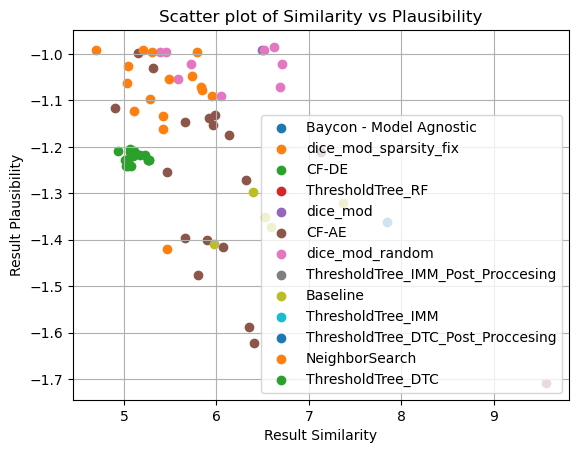

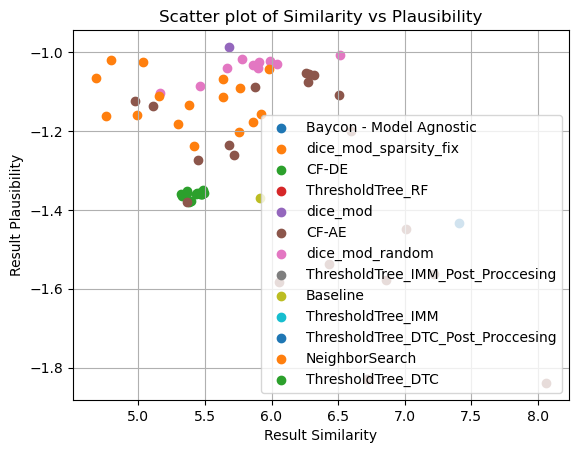

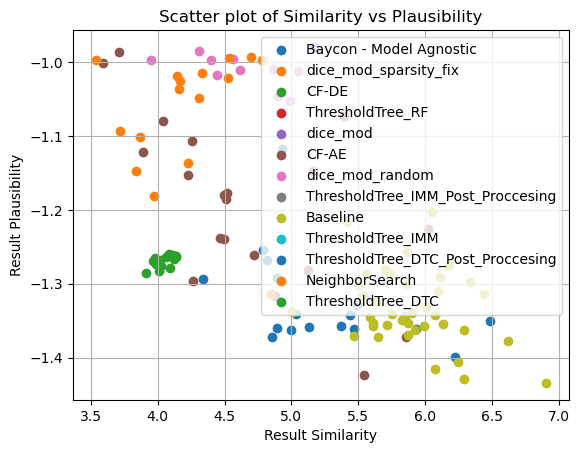

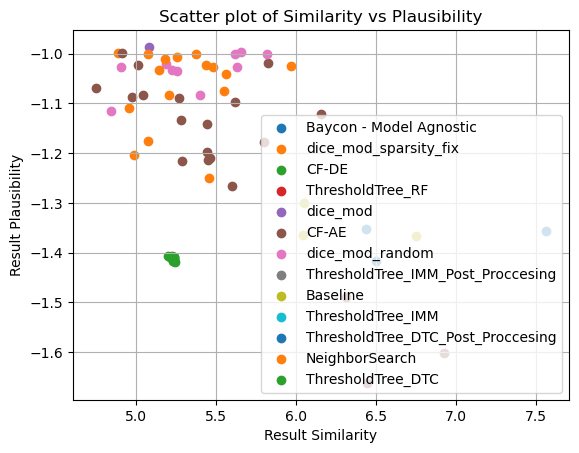

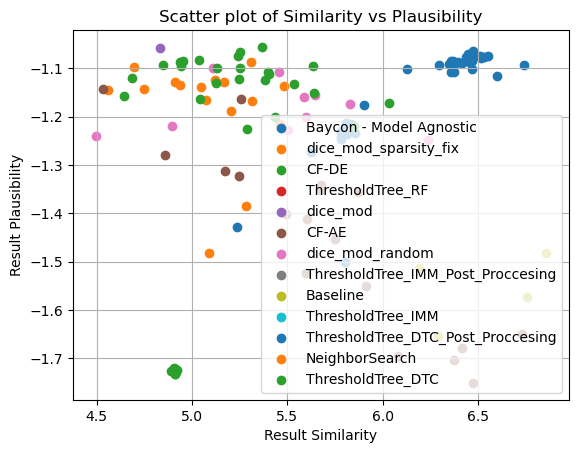

In [17]:
for i in range(5):
    plot(0,2, methodNames, results, returnNames(), plt_index=i)

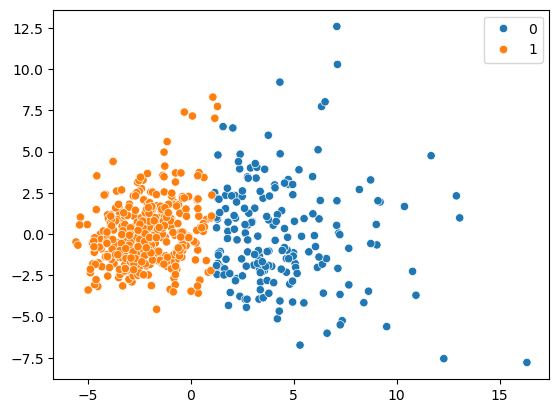

In [18]:
pca = PCA(n_components=2)
if X.shape[1] > 2:
    embed_X = pca.fit_transform(X)
else:
    embed_X = X
    
sns.scatterplot(x=embed_X[:, 0], y=embed_X[:, 1], hue=y)
plt.show()

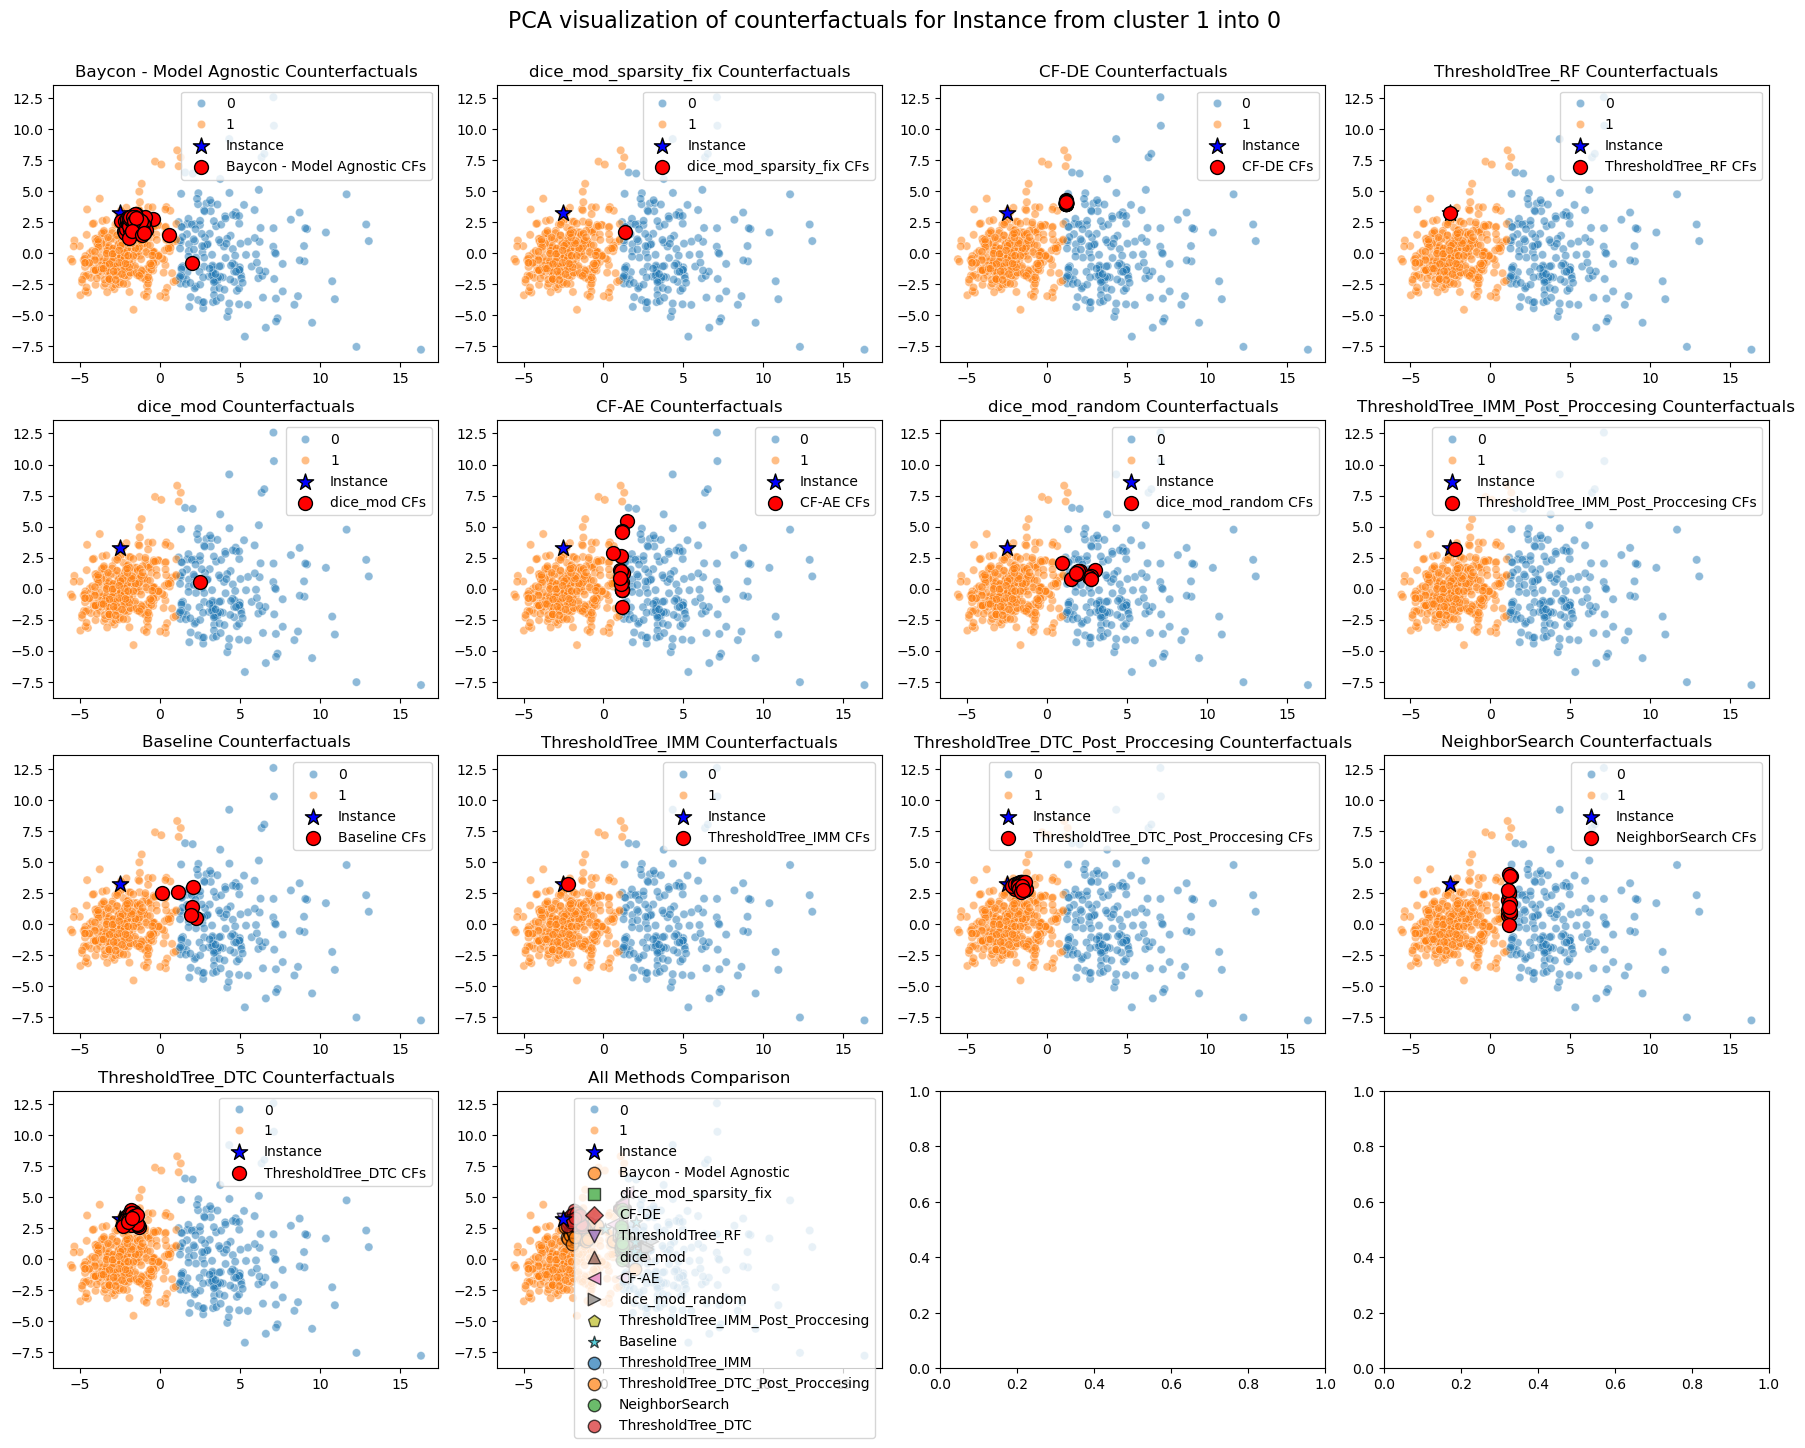

In [19]:
cf_n = 0

fig, axs = plt.subplots(4, 4, figsize=(18, 15))
axs = axs.flatten()

cffDict = methods

ins_c = cffDict[0]['counterfactuals'][cf_n].instance_label
target_c = cffDict[0]['counterfactuals'][cf_n].target

if X.shape[1] > 2:
    instance_embedded = pca.transform(X[[cffDict[0]['counterfactuals'][cf_n].instance]])
    methods_embedded = [
        (m['name'], pca.transform(m['counterfactuals'][cf_n].cf)) 
        for m in methods
    ]
else:
    instance_embedded = X[[cffDict[0]['counterfactuals'][cf_n].instance]]
    methods_embedded = [
        (m['name'], np.array(m['counterfactuals'][cf_n].cf)) 
        for m in methods
    ]

# Base scatterplot of the data
for i in range(len(methods_embedded)):
    sns.scatterplot(x=embed_X[:, 0], y=embed_X[:, 1], hue=y, alpha=0.5, ax=axs[i])
    axs[i].scatter(instance_embedded[:, 0], instance_embedded[:, 1], color='blue', s=150, 
                  marker='*', label='Instance', zorder=5, edgecolor='black')

for i, (name, embed) in enumerate(methods_embedded):
    axs[i].scatter(embed[:, 0], embed[:, 1], color='red', s=100, 
                 marker='o', label=f'{name} CFs', zorder=5, edgecolor='black')
    axs[i].set_title(f"{name} Counterfactuals")
    axs[i].legend(loc='upper right')

# Add a global title
fig.suptitle(f"PCA visualization of counterfactuals for Instance from cluster {ins_c} into {int(target_c)}", 
            fontsize=16, y=0.98)

# Final subplot for combined view
sns.scatterplot(x=embed_X[:, 0], y=embed_X[:, 1], hue=y, alpha=0.5, ax=axs[len(methods_embedded)])
axs[len(methods_embedded)].scatter(instance_embedded[:, 0], instance_embedded[:, 1], color='blue', s=150, 
              marker='*', label='Instance', zorder=5, edgecolor='black')

# Add all counterfactuals with different markers
markers = ['o', 's', 'D', 'v', '^', '<', '>', 'p', '*', 'o', 'o', 'o', 'o']
for i, (name, embed) in enumerate(methods_embedded):
    axs[len(methods_embedded)].scatter(embed[:, 0], embed[:, 1], marker=markers[i], label=name, s=80, 
                 alpha=0.7, edgecolor='black')
axs[len(methods_embedded)].set_title("All Methods Comparison")
axs[len(methods_embedded)].legend(loc='upper right')

plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()